# More fun with the Ising Model 

For my investigation, I decided to learn more about simulating the Ising model computationally. This simple system has been far more prevalent in my education over the past year than I would've ever expected, but I've never actually tried writing my own simulations with it before.

I also decided to use this project as an excuse to get to know the `Julia` programming language, as it offers a lot of very nice features for scientific computing.
Julia runs with a Just In Time compiler, which gives it a significant speed boost over Python, however it's still easy to use (and read) to the point where it could almost be mistaken for Python. The entirety of this project is done in Julia (See `README.md` for setup if it's not already installed).

In [1]:
include("lattice_functions.jl")
include("metropolis.jl")
include("wolff_cluster.jl")
using Plots
gr()

Plots.GRBackend()

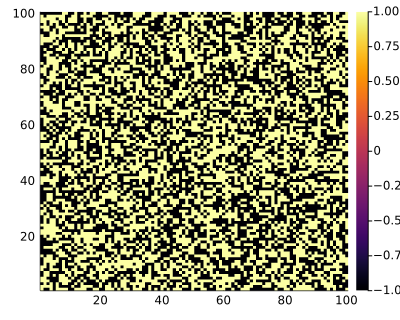

In [2]:
metr_rand = rand([-1, 1], 100, 100)
wolff_rand = copy(metr_rand)
T = 0.9
J = 1.
iters = 10
heatmap(metr_rand, size=(400,320))

Now to actually run these algorithms. To start, we just run each once with a random initial setup.
I generally found that Wolff takes much longer near criticality, but it makes significant progress every time it does. In contrast, Metropolis takes much less time but the lattice shows only minor changes. Below I run them both with the same initial setup, but Metropolis is given 100 times the number of iterations. The algorithms behave about the same at high temperatures, however at temperatures closer to criticality the Wolff Cluster algorithm takes much longer with the benefit of a much more thoroughly evolved system (see below). From simply playing with the code, I found that getting Metropolis to the same point in "lattice time" always took longer (with roughly the same number of allocations) than the Wolff Cluster algorithm.

Wolff Cluster:   1.402826 seconds (440.84 k allocations: 373.511 MiB, 1.68% gc time)

Metropolis:      0.059579 seconds (2.00 k allocations: 76.370 MiB, 3.20% gc time)


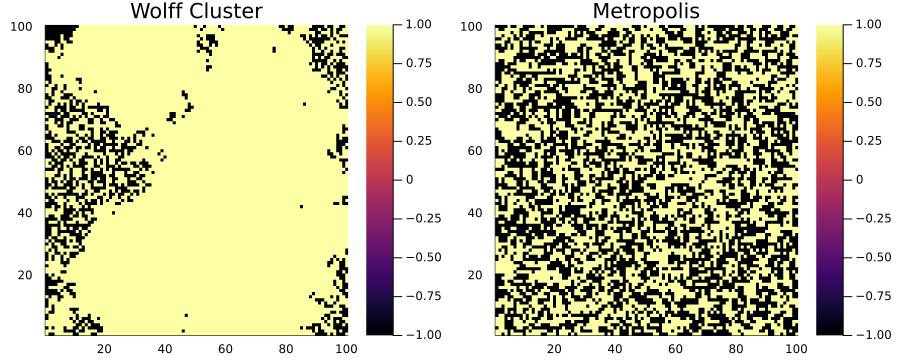

In [6]:
print("Wolff Cluster: ")
cluster_spins = @time wolff(wolff_rand, T, iters);
print("\nMetropolis:    ")
#Note, I'm giving metropolis 100*iters to compare with Wolff
metropolis_spins = @time metropolis(metr_rand, T, 100*iters);

#creating plot objects
plot_cluster = heatmap(cluster_spins, title="Wolff Cluster");
plot_metropolis = heatmap(metropolis_spins, title="Metropolis");

#plotting the plot objects together as subplots
plot(plot_cluster, plot_metropolis, size=(900,360))

Now to compute observables vs lattice time. The magnetization is an obvious candidate. I compute this as an average spin per site:
$$\frac{1}{N}\sum_i\langle s_i\rangle$$
Which is straightforward to compute (see the relevant function in `lattice_functions.jl`).
I plot this vs number of iterations, which I take to be representative of a small step forward in time. I'm performing this calculation at T = 0.8, so in the Ferromagnetic phase.

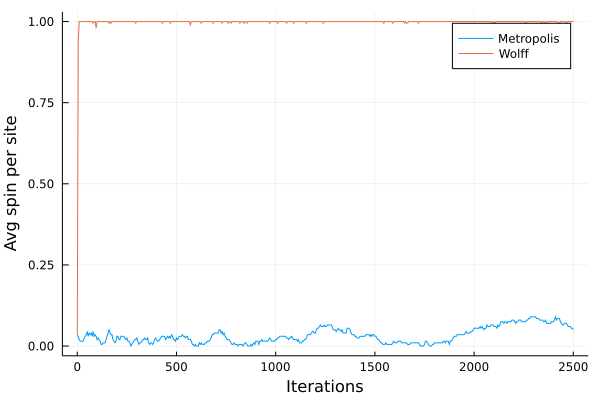

In [7]:
rand_spins = rand([-1, 1], 20, 20)
#=
We're below the critical temperature so we should get nonzero
magnetization from the system after the algorithms start working
=#
T = 0.8

#Making copies to avoid altering the original array
metro_spins = copy(rand_spins)
wolff_spins = copy(rand_spins)

#Computing the starting Magnetization
metro_mag = [compute_magnetization(metro_spins)]
wolff_mag = [compute_magnetization(wolff_spins)]

#=
for each step of the loop, run each lattice through 5 more 
iterations of the algorithm
=#

for i in 1:500
    metro_spins = metropolis(metro_spins, T, 5)
    magnetization = compute_magnetization(metro_spins)
    append!(metro_mag, magnetization)
    
    wolff_spins = wolff(wolff_spins, T, 5)
    magnetization = compute_magnetization(wolff_spins)
    append!(wolff_mag, magnetization)
end

plot(0:5:2500,[metro_mag, wolff_mag], label = ["Metropolis" "Wolff"])
xlabel!("Iterations")
ylabel!("Avg spin per site")

The Wolff algorithm unsurprisingly mimics what the actual lattice would do if released at low temperatures like this, while Metropolis still doesn't see significant magnetization after 2500 iterations. Now to look at the opposite case: an ordered lattice at high temperatures.

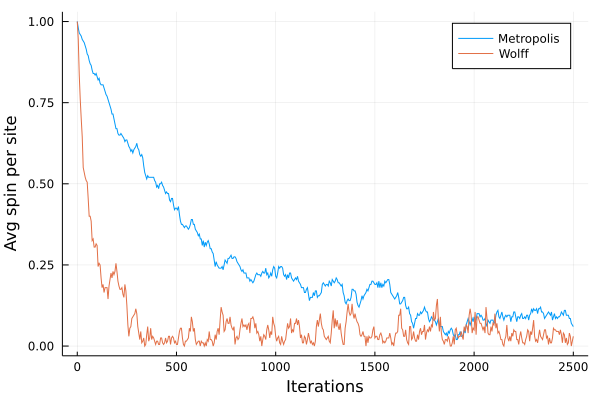

In [12]:
aligned_spins = ones(Int64, 20, 20)
#=
We're above the critical temperature so we should get nonzero
magnetization from the system after the algorithms start working
=#
T = 8.0

#Making copies to avoid altering the original array
metro_spins = copy(aligned_spins)
wolff_spins = copy(aligned_spins)

#Computing the starting Magnetization
metro_mag = [compute_magnetization(metro_spins)]
wolff_mag = [compute_magnetization(wolff_spins)]

#=
for each step of the loop, run each lattice through 5 more 
iterations of the algorithm
=#

for i in 1:500
    metro_spins = metropolis(metro_spins, T, 5)
    magnetization = compute_magnetization(metro_spins)
    append!(metro_mag, magnetization)
    
    wolff_spins = wolff(wolff_spins, T, 5)
    magnetization = compute_magnetization(wolff_spins)
    append!(wolff_mag, magnetization)
end

plot(0:5:2500,[metro_mag, wolff_mag], label = ["Metropolis" "Wolff"])
xlabel!("Iterations")
ylabel!("Avg spin per site")

The magnetization drops much faster with Wolff as expected. Now, we know from any graduate statistical mechanics text that there's a phase transition at 
$$kT = \frac{2J}{\ln(1 + \sqrt{2})}$$
which, in our case with J = 1, amounts to a critical temperature of 2.269, and both algorithms should reflect this roughly as well as each other. Looking at the above graph (and seeing similar ones from multiple runs), I'll run the Wolff algorithm for 750 iterations as I cool it, and I'll run the Metropolis algorithm for 2000 iterations through the same cooling process. Since I'm starting at high temperature, I'll once again use a random initial array.

In [14]:
rand_spins = rand([-1, 1], 20, 20)
wolff_iters = 750
metro_iters = 2000

metro_spins = copy(rand_spins)
wolff_spins = copy(rand_spins)

metro_mag = [compute_magnetization(metro_spins)]
wolff_mag = [compute_magnetization(wolff_spins)]

for T in 10:-0.5:1
    metro_spins = metropolis(metro_spins, T, metro_iters)
    magnetization = compute_magnetization(metro_spins)
    append!(metro_mag, magnetization)
    
    wolff_spins = wolff(wolff_spins, T, wolff_iters)
    magnetization = compute_magnetization(wolff_spins)
    append!(wolff_mag, magnetization)
end